In [89]:
import matplotlib.pyplot as plt
import numpy
import skimage.io
import skimage.transform
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D

## Learning Objective Error Map

In the first stage of training, the objective error maps are used as proxy regression targets to get the effect of 
increasing data. The loss function is defined by the mean squared error between the predicted and ground-truth error
maps.

\begin{align*}
\mathcal{L}_1(\hat{I}_d; \theta_f, \theta_g) = ||g(f(\hat{I}_d, \theta_f), \theta_g) - \mathbf{e}_{gt}) \odot \mathbf{\hat{r}}||^2_2
\end{align*}

where,

\begin{align*}
\mathbf{e}_{gt} = err(\hat{I}_r, \hat{I}_d)
\end{align*}

and $err(\cdot)$ is any error function. The authors decided to use

\begin{align*}
\mathbf{e}_{gt} = | \hat{I}_r -  \hat{I}_d | ^ p
\end{align*}

with $p=0.2$ in order to prevent that the values in the error map are small or close to zero.

In [90]:


@tf.function
def error_map(reference: tf.Tensor, distorted: tf.Tensor, p: float=0.2) -> tf.Tensor:
    assert reference.shape == distorted.shape, 'Both images must be of the same size'
    return tf.pow(tf.abs(reference - distorted), p)

## Reliability Map Prediction

According to the author, the model is likely to fail to predict the objective error map of
homogeneous regions without having information of its pristine image. Thus, he proposes a 
reliability function. The assumption is that blurry regions have lower reliability than textured 
regions.

\begin{align*}
\mathbf{r} = \frac{2}{1 + exp(-\alpha|\hat{I}_d|)} - 1
\end{align*}

where α controls the saturation property of the reliability map. To assign sufficiently
large values to pixels with small values, the positive part of a sigmoid is used.

In [91]:
@tf.function
def reliability_map(distorted: tf.Tensor, alpha: float) -> tf.Tensor:
    assert distorted.dtype == tf.float32, 'The Tensor must by of dtype tf.float32'
    return 2 / (1 + tf.exp(- alpha * tf.abs(distorted))) - 1

Besides, to prevent the reliability map to directly affect the predicted score,
it is divided by its average

\begin{align*}
\mathbf{\hat{r}} = \frac{1}{\frac{1}{H_rW_r}\sum_{(i,j)}\mathbf{r}(i,j)}\mathbf{r}
\end{align*}

In [92]:
@tf.function
def average_reliability_map(distorted: tf.Tensor, alpha: float) -> tf.Tensor:
    r = reliability_map(distorted, alpha)
    return r / tf.reduce_mean(r)

In [93]:
def normalize_kernel(kernel: numpy.ndarray) -> numpy.ndarray:
    return kernel / numpy.sum(kernel)


def gaussian_kernel2d(kernel_size, sigma: float):
    y, x = numpy.indices((kernel_size, kernel_size)) - int(kernel_size / 2)
    kernel = 1 / (2 * numpy.pi * sigma ** 2) * numpy.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return normalize_kernel(kernel)

In [113]:
@tf.function
def image_normalization(image: tf.Tensor) -> tf.Tensor:
    if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)
    
    shape = image.get_shape()
    rescale_size = tf.convert_to_tensor(shape[:2], dtype=tf.int32) / 4
    kernel = tf.cast(gaussian_kernel2d(16, 7/6), tf.float32)
    image_low = tf.nn.conv2d(image[tf.newaxis, :, :, :], kernel[:, :, tf.newaxis, tf.newaxis], strides=1, padding='SAME')
    image_low = tf.image.resize(
        image_low,
        tf.cast(rescale_size, tf.int32),
        tf.image.ResizeMethod.BICUBIC)
    kernel = tf.cast(gaussian_kernel2d(16, 7/6), tf.float32)
    image_low = tf.nn.conv2d(image[tf.newaxis, :, :, :], kernel[:, :, tf.newaxis, tf.newaxis], strides=1, padding='SAME')
    image_low = tf.image.resize(
        image_low,
        tf.cast(shape[:2], tf.int32),
        tf.image.ResizeMethod.BICUBIC)
    # image_low = skimage.transform.rescale(
    #     image,
    #     1 / 4,
    #     multichannel=True,
    #     anti_aliasing=True,
    #     anti_aliasing_sigma=2)
    # image_low = skimage.transform.rescale(
    #     image_low, 
    #     4,
    #     multichannel=True,
    #     anti_aliasing=True,
    #     anti_aliasing_sigma=2)
    return tf.cast(image, tf.float32) - tf.reshape(image_low, shape)

In [114]:
url_template = 'https://data.ocampor.ai/image-quality/tid2013/{image_path}'
reference_path = 'reference_images/i02.bmp'
file_paths  = [
    'distorted_images/i02_11_2.bmp',
    'distorted_images/i02_11_3.bmp',
    'distorted_images/i02_11_5.bmp']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


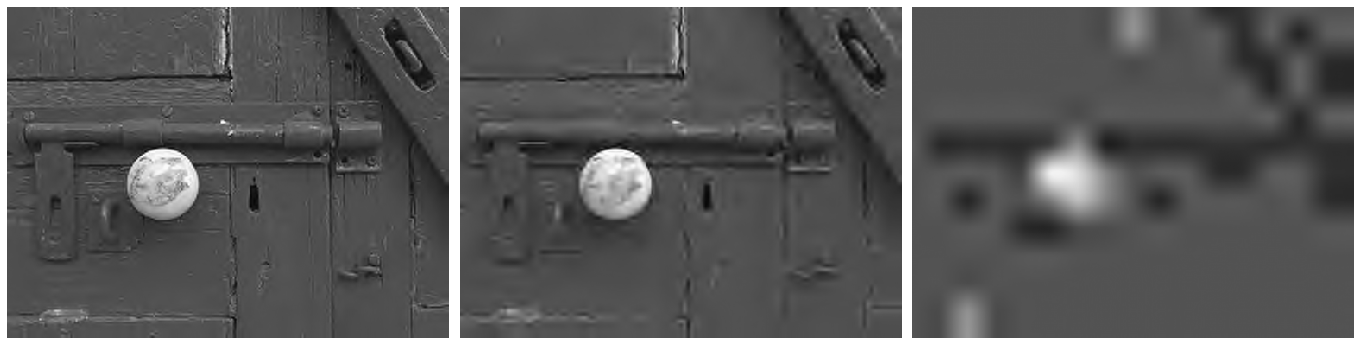

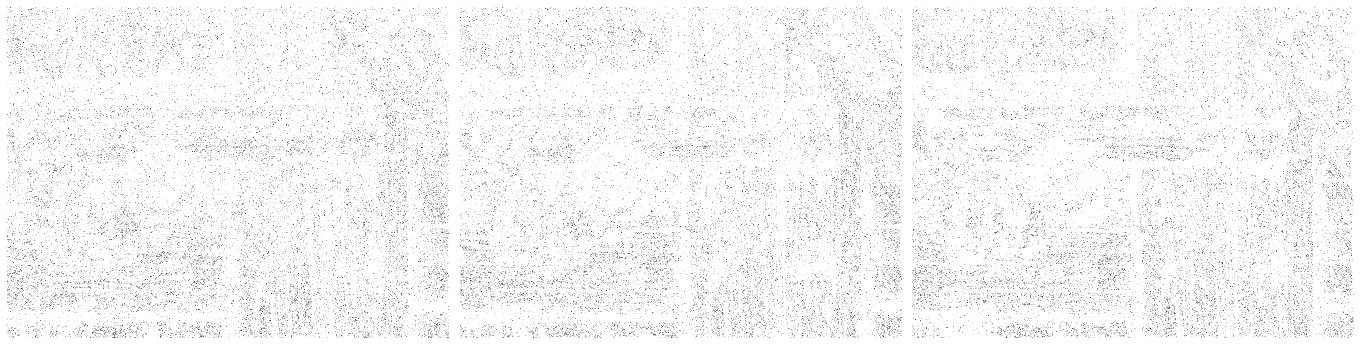

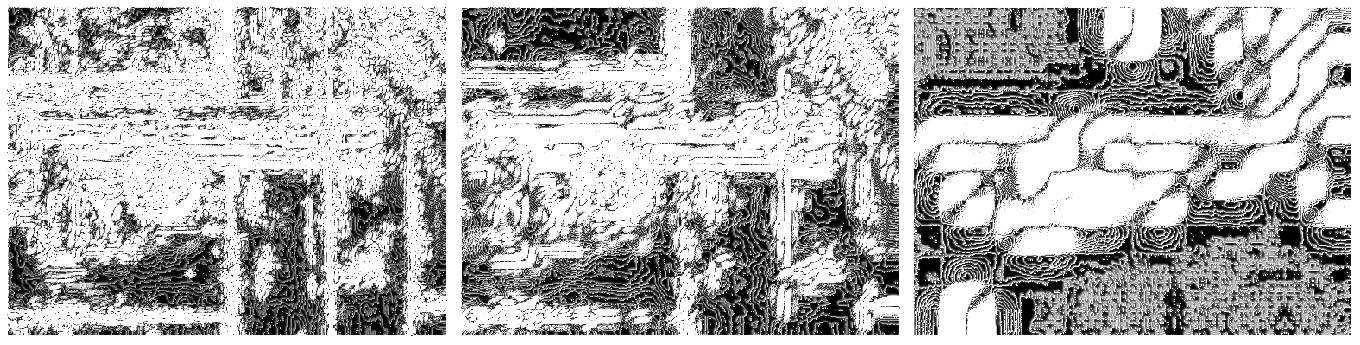

In [115]:
def show_images(images: list, **kwargs):
    fig, axs = plt.subplots(1, len(images), figsize=(19,10))
    for image, ax in zip(images, axs):
        _ = ax.imshow(image, **kwargs)
        ax.axis('off')
    fig.tight_layout()

reference = skimage.io.imread(url_template.format(image_path=reference_path))
reference = tf.image.rgb_to_grayscale(reference)
reference_d = image_normalization(reference)

e_r = list()
avg_r = list()
alpha = 1
images = list()
e_gt = list()
for path in file_paths:
    distorted = skimage.io.imread(url_template.format(image_path=path))
    distorted = tf.image.rgb_to_grayscale(distorted)
    distorted_d = image_normalization(distorted)
    
    e = error_map(reference_d, distorted_d)
    r = average_reliability_map(distorted_d, alpha)
    images.append(tf.image.grayscale_to_rgb(distorted))
    avg_r.append(tf.image.grayscale_to_rgb(r))
    e_gt.append(tf.image.grayscale_to_rgb(e))
    e_r.append(tf.image.grayscale_to_rgb(e * r))
    
show_images(images, cmap='gray')
show_images(e_gt, cmap='gray')
show_images(avg_r, cmap='gray')

In [81]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32').reshape(60000, 28, 28, 1) / 255
x_test = x_test.astype('float32').reshape(10000, 28, 28, 1) / 255
y_train = tf.image.resize(x_train, [7, 7])

In [61]:
input = tf.keras.Input(shape=(None, None, 1), batch_size=1, name='original_image')
f = Conv2D(48, (3, 3), name='Conv1', activation='relu', padding='same')(input)
f = Conv2D(48, (3, 3), name='Conv2', activation='relu', padding='same', strides=(2, 2))(f)
f = Conv2D(64, (3, 3), name='Conv3', activation='relu', padding='same')(f)
f = Conv2D(64, (3, 3), name='Conv4', activation='relu', padding='same', strides=(2, 2))(f)
f = Conv2D(64, (3, 3), name='Conv5', activation='relu', padding='same')(f)
f = Conv2D(64, (3, 3), name='Conv6', activation='relu', padding='same')(f)
f = Conv2D(128, (3, 3), name='Conv7', activation='relu', padding='same')(f)
f = Conv2D(128, (3, 3), name='Conv8', activation='relu', padding='same')(f)
g = Conv2D(1, (1, 1), name='Conv9', padding='same', activation='linear')(f)
objective_error_map = tf.keras.Model(input, g, name='objective_error_map')

In [ ]:
optimizer = tf.optimizers.Nadam(learning_rate=2 * 10 ** -4)
objective_error_map.compile(
    optimizer=optimizer,
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
objective_error_map.summary()

In [19]:
history = objective_error_map.fit(x_train, y_train,
                    batch_size=1,
                    epochs=1,
                    validation_split=0.2)

In [44]:
plt.imshow(x_test[10:11].reshape([28, 28]))
plt.show()

In [45]:
x = objective_error_map.predict(x_test[10:11])
plt.imshow(x.reshape([7, 7]))
plt.show()